# Network Intrusion Detection on the NSL-KDD Dataset

---

**Author:** Mohammad Javad Akbari
<br>**Username:** Javad-Ak

## 1. Introduction

This notebook presents a comprehensive workflow for building and evaluating machine learning models for Network Intrusion Detection (NID) using the **NSL-KDD dataset**. The primary goal is to classify network traffic as either 'normal' or one of several attack types.

We will explore, preprocess, and engineer features from the dataset to train three powerful classification models:
1.  **Random Forest:** A robust ensemble model known for its high accuracy and resistance to overfitting.
2.  **XGBoost:** A highly efficient and scalable gradient boosting implementation, often a top performer in competitions.
3.  **Deep Neural Network (DNN):** A TensorFlow-based model capable of learning complex, non-linear patterns in the data.

The process includes:
- **Data Loading and Cleaning:** Importing the dataset and preparing it for analysis.
- **Feature Engineering:** Creating new features to improve model performance.
- **Handling Class Imbalance:** Using **SMOTETomek** to create a more balanced training set, which is crucial for a dataset with rare attack categories.
- **Hyperparameter Tuning:** Employing `RandomizedSearchCV` to find the best settings for each model efficiently.
- **Model Evaluation and Comparison:** Analyzing performance metrics (Accuracy, F1-Score) and time efficiency to determine the best overall model.

## 2. Setup and Library Imports

First, we import the necessary libraries for data manipulation, machine learning, and visualization. We also set random seeds for TensorFlow and NumPy to ensure our results are reproducible.

In [3]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib

# Scikit-learn modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# TensorFlow and Keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from keras.regularizers import l2
from scikeras.wrappers import KerasClassifier

# Other libraries
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TensorFlow hardware optimization warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
# Create directories to store results and models if they don't already exist
os.makedirs('./models', exist_ok=True)
os.makedirs('./results/figures', exist_ok=True)

## 3. Data Loading and Preprocessing

We load the NSL-KDD training and testing datasets. The datasets do not contain headers, so we assign column names based on the official documentation.

In [8]:
# Define column names for the dataset
txt_cols = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'attack_type', 'difficulty_level'
]

# Load the training and testing data from the NSL_KDD directory
train_df = pd.read_csv('./NSL_KDD/KDDTrain+.txt', names=txt_cols)
test_df = pd.read_csv('./NSL_KDD/KDDTest+.txt', names=txt_cols)

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

# Display the first few rows of the data
train_df.head()

Training data shape: (125973, 43)
Testing data shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### 3.1. Data Cleaning and Attack Categorization

The `difficulty_level` column is not needed for our classification task, so we drop it.

The `attack_type` column contains many specific attack names. To create a more robust model, we group these into five main categories:
- **DoS (Denial of Service)**
- **Probe (Probing/Scanning)**
- **R2L (Root to Local)**
- **U2R (User to Root)**
- **Normal**

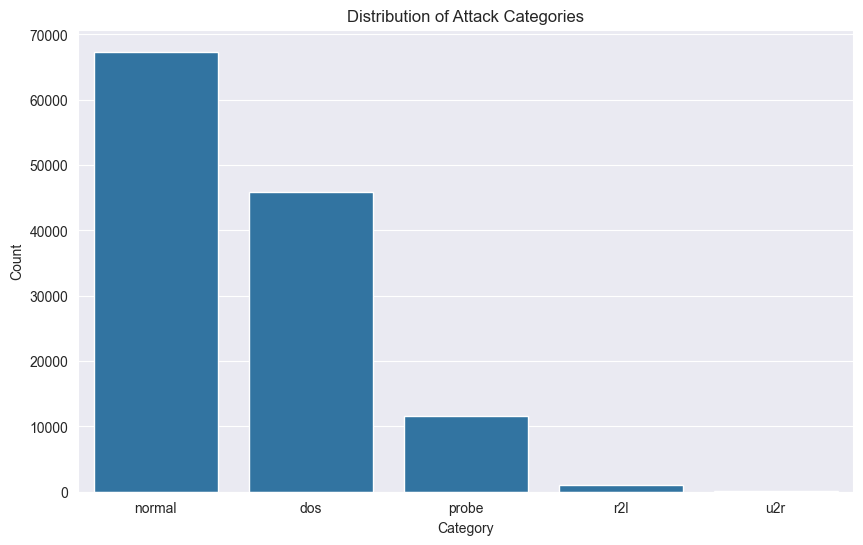

In [9]:
# Drop the 'difficulty_level' column from both dataframes
train_df.drop('difficulty_level', axis=1, inplace=True)
test_df.drop('difficulty_level', axis=1, inplace=True)

# Define the attack categories
dos = ['back', 'land', 'neptune', 'smurf', 'teardrop', 'pod', 'apache2', 'udpstorm', 'mailbomb']
probe = ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']
r2l = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'snmpgetattack', 'snmpguess',
       'warezclient', 'warezmaster', 'xlock', 'xsnoop']
u2r = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'httptunnel']

# Function to map specific attacks to their general category
def map_category(atk):
    if atk == 'normal':
        return 'normal'
    if atk in dos:
        return 'dos'
    if atk in probe:
        return 'probe'
    if atk in r2l:
        return 'r2l'
    if atk in u2r:
        return 'u2r'
    return 'dos' # Fallback for any unknown attack types

# Apply the mapping
for df in [train_df, test_df]:
    df['category'] = df['attack_type'].apply(map_category)

# Visualize the distribution of attack categories in the training data
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=train_df, order=train_df['category'].value_counts().index)
plt.title('Distribution of Attack Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

### 3.2. Label and Feature Encoding

Machine learning models require numerical input. We perform two encoding steps:
1.  **Label Encoding:** Convert the text-based `category` column into integer labels.
2.  **One-Hot Encoding:** Convert the categorical features (`protocol_type`, `service`, `flag`) into a numerical format. This prevents the model from assuming an ordinal relationship between categories.

In [10]:
# Encode the target labels
le = LabelEncoder()
le.fit(pd.concat([train_df['category'], test_df['category']]))
train_df['target'] = le.transform(train_df['category'])
test_df['target'] = le.transform(test_df['category'])

# Drop the original text columns
train_df.drop(['attack_type', 'category'], axis=1, inplace=True)
test_df.drop(['attack_type', 'category'], axis=1, inplace=True)

# One-hot encode categorical features
cat_cols = ['protocol_type', 'service', 'flag']
full_df = pd.concat([
    train_df.drop('target', axis=1),
    test_df.drop('target', axis=1)
], axis=0)
full_df_encoded = pd.get_dummies(full_df, columns=cat_cols)

### 3.3. Feature Engineering

To potentially improve model performance, we create a few new features based on domain knowledge. These engineered features can capture relationships that are not immediately apparent from the raw data.

In [ ]:
# Create new features from existing ones
full_df_encoded['bytes_ratio'] = np.where(full_df_encoded['dst_bytes'] != 0, full_df_encoded['src_bytes'] / full_df_encoded['dst_bytes'], 0)
full_df_encoded['srv_diff_ratio'] = np.where(full_df_encoded['diff_srv_rate'] != 0, full_df_encoded['same_srv_rate'] / full_df_encoded['diff_srv_rate'], 0)
full_df_encoded['error_rate_sum'] = full_df_encoded['serror_rate'] + full_df_encoded['rerror_rate']

print("Shape of the final feature matrix:", full_df_encoded.shape)